# Introduction
COVID-19 is one of the biggest issues on the planet right now. With thousands of deaths worldwide, the pandemic has affected the world's economy and lifestyle very deeply. One of the major causes of death by Corona Virus is the lack of testing in time. In many developing countries, testing is a far cry for the mass, and therefore new measurements for detection of COVID-19 are becoming essential. In this notebook, the detection of COVID-19 has been attempted using Chest X-Ray radiography images. Among the 4 CNN models used here, 3 are popular imagenet trained models; VGG16, ResNet101 and Xception, and a simple CNN model. The work here is heavily inspired by the amazing tutorial of [Adrian Rosebrock](https://www.linkedin.com/in/adrian-rosebrock-59b8732a) at [Pyimagesearch](https://www.pyimagesearch.com/2020/03/16/detecting-covid-19-in-x-ray-images-with-keras-tensorflow-and-deep-learning/). The dataset primarily used is the [COVID-19 Radiography Database](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database) which can be found in Kaggle. The plan is to make a continuously upgradable framework to integrate new data published on this topic every week. **I am an absolute beginner in the world of data science and machine learning. So expect this work to be vastly immature and incomplete in many regards !**

Lastly, to quote the pyimagesearch tutorial,
> It’s possible that this model is learning patterns that are not relevant to COVID-19, and instead are just variations between the two data splits (i.e., positive versus negative COVID-19 diagnosis). It would take a trained medical professional and rigorous testing to validate the results coming out of our COVID-19 detector. Future (and better) COVID-19 detectors will be multi-modal. Right now we are using only image data (i.e., X-rays) — better automatic COVID-19 detectors should leverage multiple data sources not limited to just images, including patient vitals, population density, geographical location, etc. Image data by itself is typically not sufficient for these types of applications. For these reasons, it must once again be stressed that this notebook is meant for educational purposes only — it is not meant to be a robust COVID-19 detector. If you believe that yourself or a loved one has COVID-19, you should follow the protocols outlined by the Center for Disease Control (CDC), World Health Organization (WHO), or local country, state, or jurisdiction.

In [1]:
!pip install imutils

  Created wheel for imutils: filename=imutils-0.5.3-py3-none-any.whl size=25850 sha256=e087a100d14549afc92b4e1d5edbbdf984c0d08524d69752dfb55527797d251a
  Stored in directory: /root/.cache/pip/wheels/fc/9c/6d/1826267c72afa51b564c9c6e0f66abc806879338bc593a2270
Successfully built imutils


# Imports

In [2]:
import cv2
import os, glob

import numpy as np
import seaborn as sns
from imutils import paths
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet101, Xception
from tensorflow.keras.layers import Input, Dense, Flatten, AveragePooling2D, Dropout, BatchNormalization, Conv2D

# Data Processing

**Setting Hyperparameter values to be used in CNN. These can be changed to tune the networks performance.**

In [3]:
LR = 0.001
EPOCHS = 20
BATCH_SIZE = 32
COVID_LEN = 218
INP_SIZE = (224,224,3)

**Image to data list transformation. Directories needs to changed for different input setup.**

In [4]:
def create_data(dir_name):
    temp_data = []
    img_list = glob.glob('../' + dir_name + '/*')
    for img in img_list[:COVID_LEN]:
        image = cv2.imread(img)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))
        temp_data.append(image)
    return temp_data

data = []
labels = []

covid_dir = 'input/covid19-radiography-database/COVID-19 Radiography Database/COVID-19'
normal_dir = 'input/covid19-radiography-database/COVID-19 Radiography Database/NORMAL'
pneumonia_dir = 'input/covid19-radiography-database/COVID-19 Radiography Database/Viral Pneumonia'

data.extend(create_data(covid_dir))
data.extend(create_data(normal_dir))
data.extend(create_data(pneumonia_dir))

labels.extend([1] * COVID_LEN)
labels.extend([0]*2*COVID_LEN)

data = np.array(data)/255.0
labels = np.array(labels)

print(data.shape)
print(labels.shape)

(654, 224, 224, 3)
(654,)


In [5]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

(x_train, x_test, y_train, y_test) = train_test_split(
    data,
    labels,
    test_size=0.20,
    stratify=labels,
    random_state=42
)
trainAug = ImageDataGenerator(
    rotation_range=15,
    fill_mode="nearest"
)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(523, 224, 224, 3)
(523, 2)
(131, 224, 224, 3)
(131, 2)


# Model Generation and Fitting

**Functions for generating Custom and Pretrained models.**

In [6]:
def generate_custom_model():
    
    model = Sequential()
    model.add(BatchNormalization(input_shape=INP_SIZE))
    model.add(Conv2D(16, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(Conv2D(16, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(AveragePooling2D(pool_size=(2,2)))
    model.add(Dropout(0.35))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.35))
    model.add(Dense(2, activation='softmax'))
    
    return model

def generate_pretrained_model(model_name):
    if model_name == 'VGG16':
        model = VGG16(
            include_top = False,
            weights = 'imagenet',
            input_tensor = Input(shape=INP_SIZE)
        )
    elif model_name == 'ResNet101':
        model = ResNet101(
            include_top = False,
            weights = 'imagenet',
            input_tensor = Input(shape=INP_SIZE)
        )
    elif model_name == 'Xception':
        model = Xception(
            include_top = False,
            weights = 'imagenet',
            input_tensor = Input(shape=INP_SIZE)
        )
    else:
        model = None
        print('Invalid Choice!')
    
    return model

**Fitting model according to input. Various parameters here can be changed for better model tuning.**

In [7]:
def fit_model(model, model_name):
    optim = Adam(lr = LR, decay = LR/EPOCHS)
    
    if model_name == 'Custom':
        model.compile(loss="categorical_crossentropy", optimizer=optim, metrics=["accuracy"])
        history = model.fit_generator(
            trainAug.flow(x_train, y_train, batch_size = BATCH_SIZE),
            steps_per_epoch = len(x_train) // BATCH_SIZE,
            validation_data = (x_test, y_test),
            validation_steps = len(x_test) // BATCH_SIZE,
            epochs = EPOCHS
        )
    else :
        for layer in model.layers:
            layer.trainable = False
        # top layer for shaping output    
        headModel = model.output
        headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
        headModel = Flatten(name="flatten")(headModel)
        headModel = Dense(64, activation="relu")(headModel)
        headModel = Dropout(0.5)(headModel)
        headModel = Dense(2, activation="softmax")(headModel)
        model = Model(inputs=model.input, outputs=headModel)
        model.compile(loss="categorical_crossentropy", optimizer=optim, metrics=["accuracy"])
        
        history = model.fit_generator(
            trainAug.flow(x_train, y_train, batch_size = BATCH_SIZE),
            steps_per_epoch = len(x_train) // BATCH_SIZE,
            validation_data = (x_test, y_test),
            validation_steps = len(x_test) // BATCH_SIZE,
            epochs = EPOCHS
        )
    
    return history, model

# Plotting Methods

In [8]:
def display_history(history_):
    fig, ax = plt.subplots(1,2, figsize=(12, 3))
    ax[0].plot(history_.history['loss'], color='b', label="training_loss")
    ax[0].plot(history_.history['val_loss'], color='r', label="validation_loss",axes =ax[0])
    legend = ax[0].legend(loc='best', shadow=True)

    ax[1].plot(history_.history['accuracy'], color='b', label="training_accuracy")
    ax[1].plot(history_.history['val_accuracy'], color='r',label="validation_accuracy")
    legend = ax[1].legend(loc='best', shadow=True)

def plot_metrices(model_):
    
    plt.figure()
    ax = plt.subplot()
    ax.set_title('Confusion Matrix')
    
    pred = model_.predict(x_test, batch_size = BATCH_SIZE)
    pred = np.argmax(pred, axis = 1)
    cm = confusion_matrix(y_test.argmax(axis = 1), pred)
    classes=['normal', 'covid19']
    sns.heatmap(cm, annot = True, xticklabels = classes, yticklabels = classes, cmap = 'Reds')

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show
    
    print(classification_report(y_test.argmax(axis = 1), pred))
    total = sum(sum(cm))
    acc = (cm[0, 0] + cm[1, 1]) / total
    sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
    
    print("ACC: {:.4f}".format(acc))
    print("Sensitivity: {:.4f}".format(sensitivity))
    print("Specificity: {:.4f}".format(specificity))

# Function Calls

**Genereate models**

In [9]:
custom_mod = generate_custom_model()
vgg_mod = generate_pretrained_model('VGG16')
resnet_mod = generate_pretrained_model('ResNet101')
xception_mod = generate_pretrained_model('Xception')

83689472/83683744 [==============================] - 2s 0us/step


**Custom Model**

Epoch 1/20
16/16 [==============================] - 5s 318ms/step - loss: 6.1895 - accuracy: 0.7678 - val_loss: 0.3652 - val_accuracy: 0.9160
Epoch 2/20
16/16 [==============================] - 5s 305ms/step - loss: 0.4021 - accuracy: 0.8921 - val_loss: 0.5363 - val_accuracy: 0.8779
Epoch 3/20
16/16 [==============================] - 5s 283ms/step - loss: 0.2456 - accuracy: 0.9267 - val_loss: 0.5171 - val_accuracy: 0.9008
Epoch 4/20
16/16 [==============================] - 5s 301ms/step - loss: 0.1809 - accuracy: 0.9348 - val_loss: 0.7933 - val_accuracy: 0.3740
Epoch 5/20
16/16 [==============================] - 5s 284ms/step - loss: 0.2071 - accuracy: 0.9206 - val_loss: 0.3321 - val_accuracy: 0.9008
Epoch 6/20
16/16 [==============================] - 5s 304ms/step - loss: 0.1463 - accuracy: 0.9369 - val_loss: 0.2851 - val_accuracy: 0.9466
Epoch 7/20
16/16 [==============================] - 5s 307ms/step - loss: 0.1506 - accuracy: 0.9336 - val_loss: 0.2454 - val_accuracy: 0.9389
Epoch 

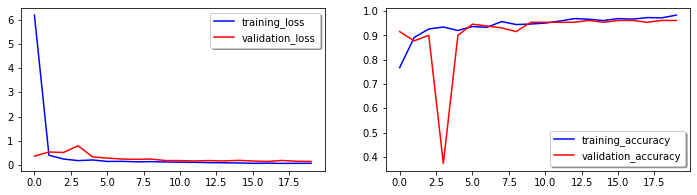

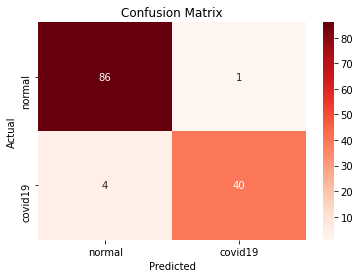

In [10]:
(cus_his, custom_mod) = fit_model(custom_mod, 'Custom')
display_history(cus_his)
plot_metrices(custom_mod)
custom_mod.save('custom.h5')

**VGG16 Model**

Epoch 1/20
16/16 [==============================] - 6s 398ms/step - loss: 0.6663 - accuracy: 0.6387 - val_loss: 0.5571 - val_accuracy: 0.6641
Epoch 2/20
16/16 [==============================] - 5s 336ms/step - loss: 0.5163 - accuracy: 0.7495 - val_loss: 0.4610 - val_accuracy: 0.8168
Epoch 3/20
16/16 [==============================] - 5s 332ms/step - loss: 0.4461 - accuracy: 0.8004 - val_loss: 0.4042 - val_accuracy: 0.8168
Epoch 4/20
16/16 [==============================] - 5s 325ms/step - loss: 0.3867 - accuracy: 0.8452 - val_loss: 0.3515 - val_accuracy: 0.9008
Epoch 5/20
16/16 [==============================] - 5s 331ms/step - loss: 0.3280 - accuracy: 0.8595 - val_loss: 0.3119 - val_accuracy: 0.9008
Epoch 6/20
16/16 [==============================] - 5s 316ms/step - loss: 0.3054 - accuracy: 0.8778 - val_loss: 0.2904 - val_accuracy: 0.9084
Epoch 7/20
16/16 [==============================] - 5s 336ms/step - loss: 0.2794 - accuracy: 0.8859 - val_loss: 0.2723 - val_accuracy: 0.9466
Epoch 

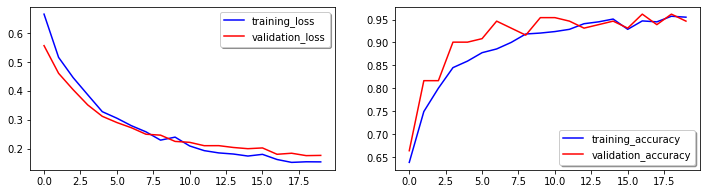

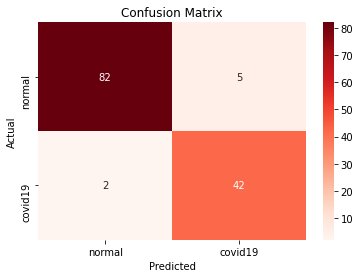

In [11]:
(vgg_his, vgg_mod)= fit_model(vgg_mod, 'VGG16')
display_history(vgg_his)
plot_metrices(vgg_mod)
vgg_mod.save('vgg.h5')

**ResNet101 Model**

Epoch 1/20
16/16 [==============================] - 8s 485ms/step - loss: 0.7398 - accuracy: 0.6069 - val_loss: 0.6025 - val_accuracy: 0.6641
Epoch 2/20
16/16 [==============================] - 5s 335ms/step - loss: 0.6196 - accuracy: 0.6762 - val_loss: 0.5794 - val_accuracy: 0.6641
Epoch 3/20
16/16 [==============================] - 6s 346ms/step - loss: 0.5936 - accuracy: 0.6802 - val_loss: 0.5803 - val_accuracy: 0.6641
Epoch 4/20
16/16 [==============================] - 5s 339ms/step - loss: 0.5887 - accuracy: 0.6965 - val_loss: 0.5983 - val_accuracy: 0.6641
Epoch 5/20
16/16 [==============================] - 5s 327ms/step - loss: 0.6356 - accuracy: 0.6456 - val_loss: 0.5513 - val_accuracy: 0.6641
Epoch 6/20
16/16 [==============================] - 6s 358ms/step - loss: 0.5648 - accuracy: 0.6895 - val_loss: 0.5196 - val_accuracy: 0.7557
Epoch 7/20
16/16 [==============================] - 5s 326ms/step - loss: 0.5422 - accuracy: 0.7189 - val_loss: 0.5060 - val_accuracy: 0.7710
Epoch 

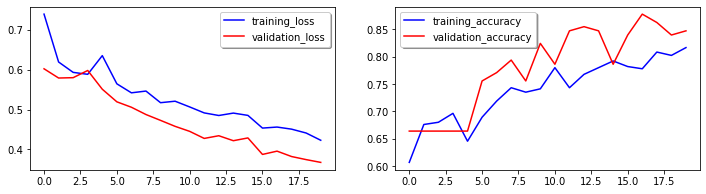

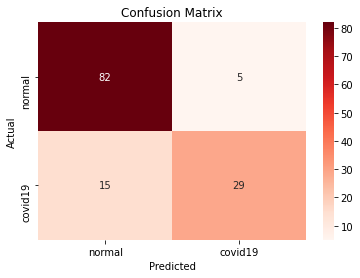

In [12]:
res_his, resnet_mod = fit_model(resnet_mod, 'ResNet101')
display_history(res_his)
plot_metrices(resnet_mod)
resnet_mod.save('resnet.h5')

**Xception Model**

Epoch 1/20
16/16 [==============================] - 6s 384ms/step - loss: 0.2988 - accuracy: 0.8635 - val_loss: 0.1237 - val_accuracy: 0.9542
Epoch 2/20
16/16 [==============================] - 5s 326ms/step - loss: 0.1931 - accuracy: 0.9369 - val_loss: 0.1263 - val_accuracy: 0.9389
Epoch 3/20
16/16 [==============================] - 5s 312ms/step - loss: 0.1381 - accuracy: 0.9470 - val_loss: 0.0889 - val_accuracy: 0.9542
Epoch 4/20
16/16 [==============================] - 5s 330ms/step - loss: 0.1023 - accuracy: 0.9654 - val_loss: 0.1107 - val_accuracy: 0.9466
Epoch 5/20
16/16 [==============================] - 5s 330ms/step - loss: 0.1060 - accuracy: 0.9674 - val_loss: 0.0641 - val_accuracy: 0.9618
Epoch 6/20
16/16 [==============================] - 5s 333ms/step - loss: 0.0829 - accuracy: 0.9756 - val_loss: 0.0544 - val_accuracy: 0.9771
Epoch 7/20
16/16 [==============================] - 5s 328ms/step - loss: 0.0831 - accuracy: 0.9746 - val_loss: 0.0482 - val_accuracy: 0.9771
Epoch 

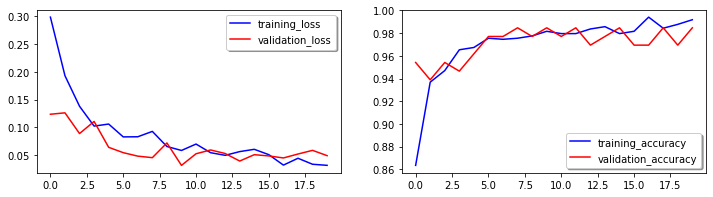

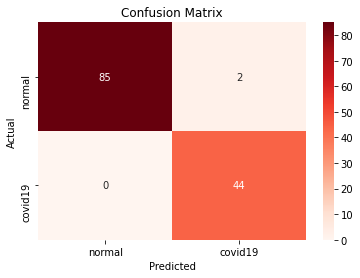

In [13]:
xcep_his, xception_mod = fit_model(xception_mod, 'Xception')
display_history(xcep_his)
plot_metrices(xception_mod)
xception_mod.save('xception.h5')